## akshataupadhye/finetuning-sentiment-model-reddit-data

Anche il secondo modello che andrò a testare è disponibile su <a href="https://huggingface.co/akshataupadhye/finetuning-sentiment-model-reddit-data">Hugging Face</a>.
Questo modello si basa su distilbert-base-uncased.


# Dataset

In [2]:
from datasets import Dataset, load_dataset, ClassLabel, Value, Features, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import pandas as pd
import torch

class RedditDataset:
  """
    La classe RedditDataset si occupa di rappresentare il dataset che viene usato per l'addestramento, occupandosi anche della divisione tra Train, Test e Validation
  """

  def __init__(self, csv_file : str, scale : bool = False):
    """
      Costruttore della classe, che si occupa di caricare il file indicato dal parametro csv_file.
      Inoltre divide il dataset in Train (80%), Test (10%) e Validation (10%).

    PARAMETRI:
      csv_file (str): percorso del file csv da caricare
      scale (bool): se True aumenta di uno le label del dataset (default False)
    """
    data = pd.read_csv(csv_file, on_bad_lines='skip')
    data.dropna(inplace=True)

    if len(data) == 0:
      raise ValueError("Dataset vuoto")

    if scale:
      data["category"] = data["category"] + 1

    unique_labels = [str(label) for label in sorted(data["category"].dropna().unique())]

    features = Features({
      'clean_comment': Value('string'),
      'category': ClassLabel(names=unique_labels)
    })

    train, temp_data = train_test_split(data, test_size=0.2, stratify=data["category"], random_state=42)
    validation, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data["category"], random_state=42)

    self.dataset = DatasetDict({
      'train': Dataset.from_pandas(train, features=features, preserve_index=False),
      'validation': Dataset.from_pandas(validation, features=features, preserve_index=False),
      'test': Dataset.from_pandas(test, features=features, preserve_index=False)
    })

  def _tokenize(self, batch : dict, tokenizer : AutoTokenizer) -> dict:
    """
      Tokenizza una lista di commenti testuali usando il tokenizer fornito.

    PARAMETRI:
        batch (dict): Dizionario contenente la chiave 'clean_comment' con una lista di commenti da tokenizzare.
        tokenizer (AutoTokenizer): Un oggetto tokenizer compatibile che converte il testo in token.

    RITORNA:
        dict: Risultato della tokenizzazione
    """
    comments = batch['clean_comment']
    return tokenizer(comments, padding="max_length", truncation=True, max_length=128)

  def _cast_labels_to_int(self, batch : dict) -> dict:
    """
      Converte le etichette testuali/numeriche in interi long tensor per l'addestramento del modello.

    PARAMETRI:
        batch (dict): Dizionario contenente la chiave 'category' con le etichette grezze (stringhe o numeri).

    RITORNA:
        dict: Il batch aggiornato
    """
    batch["labels"] = [int(label) for label in batch["category"]]
    batch["labels"] = torch.tensor(batch["labels"], dtype=torch.long)
    return batch

  def prepare_dataset(self, tokenizer : AutoTokenizer):
    """
      Operazioni che si vanno ad efetturare al dataset prima dell'addestramento.
      In particolare si vanno a creare i token e si castano le label in interi.

    PARAMETRI:
      tokenizer (Tokenizer): tokenizer da utilizzare
    """
    for split in self.dataset:

      self.dataset[split] = self.dataset[split].map(self._tokenize, batched=True, fn_kwargs={'tokenizer': tokenizer})
      self.dataset[split] = self.dataset[split].map(self._cast_labels_to_int, batched=True)

  def get_train_dataset(self) -> Dataset:
    """
      Restituisce il dataset di addestramento.

    RITORNA:
      Dataset (Dataset): Il dataset di addestramento.
    """
    return self.dataset["train"]

  def get_validation_dataset(self) -> Dataset:
    """
      Restituisce il dataset di validazione.

    RITORNA:
      Dataset (Dataset): Il dataset di validazione.
    """
    return self.dataset["validation"]

  def get_test_dataset(self) -> Dataset:
    """
      Restituisce il dataset di test.

    RITORNA:
      Dataset (Dataset): Il dataset di test.
    """
    return self.dataset["test"]

  def print(self):
    """
      Stampa il dataset, principalmente per scopo di debug
    """
    for split in self.dataset:
      print(f"{split} split: {self.dataset[split]}")


# Modello

Per rapperesentare il modello è stata usata la classe SentimentAnalysisModel

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch


class MetricsLoggerCallback(TrainerCallback):
    def __init__(self, trainer):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.train_accuracies = []
        self.trainer = trainer

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 500 == 0 and state.global_step > 0:

            train_output = self.trainer.evaluate(self.trainer.train_dataset)
            eval_output = self.trainer.evaluate()

            self.train_losses.append(train_output["eval_loss"])
            self.train_accuracies.append(train_output["eval_accuracy"])

            self.eval_losses.append(eval_output["eval_loss"])
            self.eval_accuracies.append(eval_output["eval_accuracy"])

    def plot(self):
        steps = [i * 500 for i in range(1, len(self.train_losses) + 1)]

        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(steps, self.train_losses, label="Train Loss")
        plt.plot(steps, self.eval_losses, label="Eval Loss")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Loss over Training")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(steps, self.train_accuracies, label="Train Accuracy")
        plt.plot(steps, self.eval_accuracies, label="Eval Accuracy")
        plt.xlabel("Steps")
        plt.ylabel("Accuracy")
        plt.title("Accuracy over Training")
        plt.legend()

        plt.tight_layout()
        plt.show()


class SentimentAnalysisModel:
    """
        Classe che si occupa di gestire il modello di Sentiment Analysis
        Si occupa di preparare il trainer, addestrare il modello e stampare i report.
    """
    def __init__(self):
        """
            Inizializza il modello di Sentiment Analysis, il tokenizer e il modello pre-addestrato.
            Il modello utilizzato è 'akshataupadhye/finetuning-sentiment-model-reddit-data'.
        """
        model_name = "akshataupadhye/finetuning-sentiment-model-reddit-data"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, problem_type="single_label_classification")
        self.trainer = None
        self.logger = None

    def prepare_trainer(self, dataset_train: Dataset, dataset_eval: Dataset):
        """
            Prepara il trainer per l'addestramento del modello.

        PARAMETRI:
            dataset_train (Dataset): Il dataset di addestramento.
            dataset_eval (Dataset): Il dataset di valutazione.
        """
        training_args = TrainingArguments(
            output_dir="./results",
            report_to="none",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_strategy="epoch",
            eval_strategy="steps",
            eval_steps=500,
            logging_steps=500,
        )
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=dataset_train,
            eval_dataset=dataset_eval,
            tokenizer=self.tokenizer,
            compute_metrics=self._compute_metrics,
            callbacks=[]
        )
        self.logger = MetricsLoggerCallback(self.trainer)
        self.trainer.add_callback(self.logger)

    def get_tokenizer(self):
        """
            Restituisce il tokenizer utilizzato dal modello.
        RITORNA:
            AutoTokenizer: Il tokenizer utilizzato per il modello.
        """
        return self.tokenizer

    def _compute_metrics(self, eval_pred):
        """
            Calcola le metriche di valutazione per il modello, in particolare l'accurate
            e il F1 score.
        PARAMETRI:
            eval_pred: Le predizioni da valutare.
        RITORNA:
            dict: Un dizionario contenente le metriche calcolate.
        """
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average="weighted")
        }

    def train(self):
        """
            Avvia l'addestramento del modello e, una volta terminato, mostra le metriche di addestramento.
        """
        if self.trainer is None:
            raise ValueError("Trainer non inizializzato")
        self.trainer.train()
        self.logger.plot()

    def print_report(self, dataset_test: Dataset, is_pre_finetuning=False, confusion_matrix_path="/content/drive/MyDrive/confusion_matrix-finetuning-sentiment-model-reddit-data"):
        """
            Stampa il report delle prestazioni del modello sul dataset di test.
        PARAMETRI:
            dataset_test (Dataset): Il dataset di test su cui valutare il modello.
            is_pre_finetuning (bool): Indica se la valutazione è pre-addestramento (default False).
            confusion_matrix_path (str): Percorso dove salvare la matrice di confusione (default "/content/drive/MyDrive/confusion_matrix-twitter-roberta-base-sentiment").
        """
        if self.trainer is None:
            raise ValueError("Trainer non inizializzato")

        label_names = ["Negativo", "Neutrale", "Positivo"]

        predictions = self.trainer.predict(dataset_test)
        y_true = predictions.label_ids
        y_pred = np.argmax(predictions.predictions, axis=1)

        cm = confusion_matrix(y_true, y_pred, normalize='true')

        print(f"\nConfusion Matrix:\n{cm}")

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
        plt.xlabel("Predetto")
        plt.ylabel("Reale")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.savefig(f"{confusion_matrix_path}{'-prefinetuning' if is_pre_finetuning else '-finetuned'}.png")
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=label_names))

        metrics = self.trainer.evaluate()
        print("\nStatistiche finali sul test set:")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

    def save(self, model_save_path: str):
        """
            Salva il modello e il tokenizer nel percorso specificato.
        PARAMETRI:
            model_save_path (str): Il percorso dove salvare il modello e il tokenizer.
        """
        if self.trainer is None:
            raise ValueError("Trainer non inizializzato")
        self.trainer.save_model(model_save_path)
        self.tokenizer.save_pretrained(model_save_path)


# Addestramento

In questo script viene fatto l'addestramento della rete, con un Learning Rate pari a 5e-5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/29719 [00:00<?, ? examples/s]

Map:   0%|          | 0/29719 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Statistiche pre-fine tuning:


/tmp/ipython-input-11-1043695235.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(



Confusion Matrix:
[[0.82345828 0.06287787 0.11366385]
 [0.04291188 0.91494253 0.04214559]
 [0.06127606 0.03411244 0.9046115 ]]


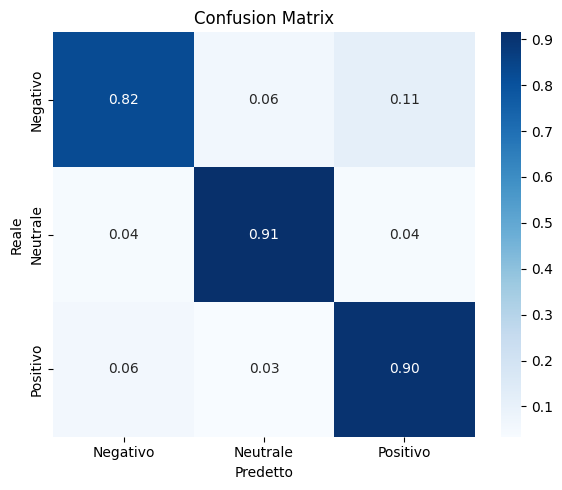


Classification Report:
              precision    recall  f1-score   support

    Negativo       0.82      0.82      0.82       827
    Neutrale       0.92      0.91      0.92      1305
    Positivo       0.91      0.90      0.91      1583

    accuracy                           0.89      3715
   macro avg       0.88      0.88      0.88      3715
weighted avg       0.89      0.89      0.89      3715




Statistiche finali sul test set:
eval_loss: 0.4027
eval_model_preparation_time: 0.0014
eval_accuracy: 0.8902
eval_f1: 0.8903
eval_runtime: 14.3423
eval_samples_per_second: 259.0240
eval_steps_per_second: 32.4220
Inizio Addestramento


Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
500,No log,0.513951,0.001400,0.844415,0.832529
1000,No log,0.322610,0.001400,0.883715,0.885598
1500,No log,0.364059,0.001400,0.902019,0.902489
2000,No log,0.361940,0.001400,0.903634,0.904001
2500,No log,0.267900,0.001400,0.918977,0.918006
3000,No log,0.305983,0.001400,0.925168,0.924764
3500,No log,0.287832,0.001400,0.935935,0.936237
4000,No log,0.263663,0.001400,0.939166,0.938892
4500,No log,0.314173,0.001400,0.935397,0.935988
5000,No log,0.256795,0.001400,0.933782,0.934059


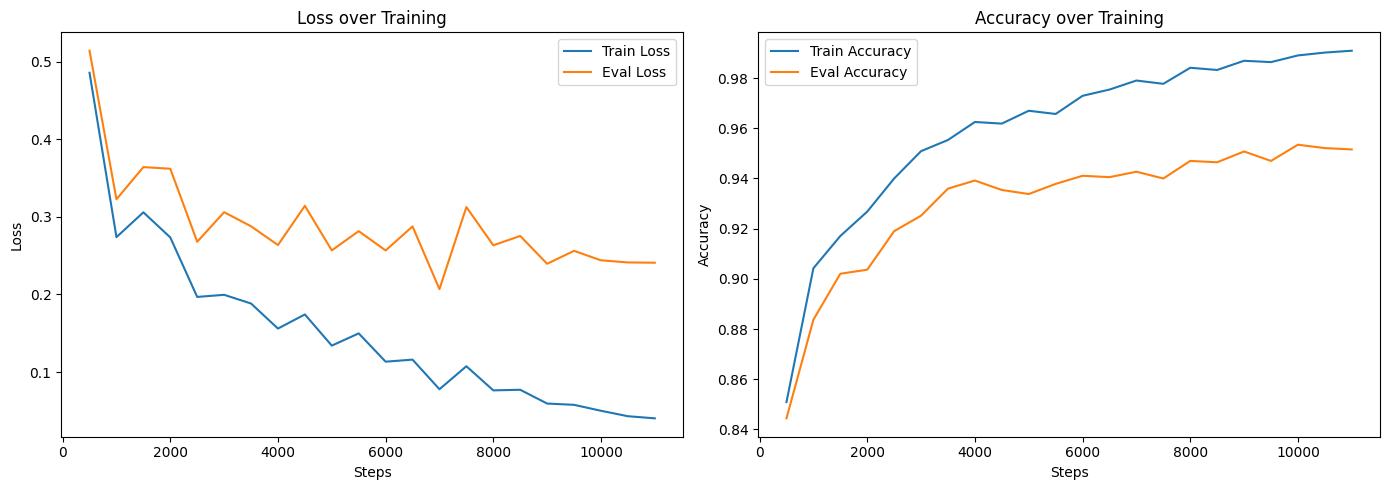

Fine Addestramento
Statistiche post-fine tuning:



Confusion Matrix:
[[0.91414752 0.01692866 0.06892382]
 [0.01226054 0.96934866 0.0183908 ]
 [0.03790272 0.0050537  0.95704359]]


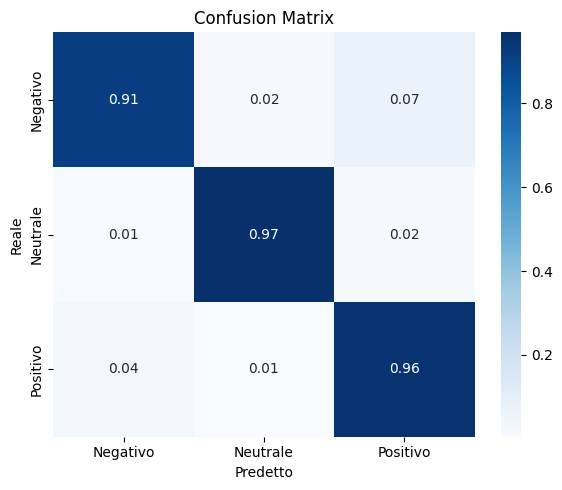


Classification Report:
              precision    recall  f1-score   support

    Negativo       0.91      0.91      0.91       827
    Neutrale       0.98      0.97      0.98      1305
    Positivo       0.95      0.96      0.95      1583

    accuracy                           0.95      3715
   macro avg       0.95      0.95      0.95      3715
weighted avg       0.95      0.95      0.95      3715




Statistiche finali sul test set:
eval_loss: 0.2412
eval_model_preparation_time: 0.0014
eval_accuracy: 0.9518
eval_f1: 0.9519
eval_runtime: 13.9606
eval_samples_per_second: 266.1060
eval_steps_per_second: 33.3080
epoch: 3.0000
Statistiche di Test

Confusion Matrix:
[[0.91304348 0.01449275 0.07246377]
 [0.01303681 0.9708589  0.01610429]
 [0.03916614 0.00568541 0.95514845]]


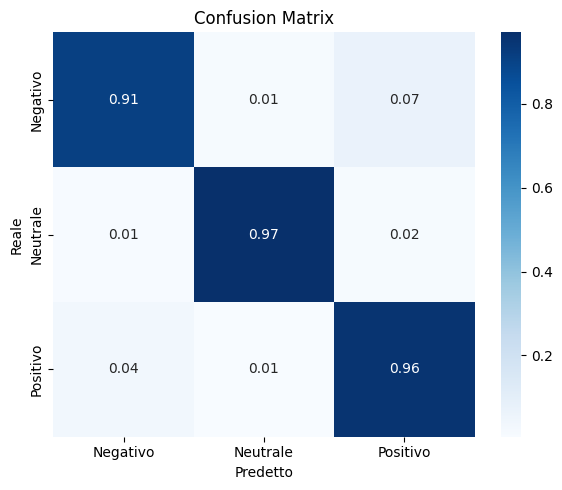


Classification Report:
              precision    recall  f1-score   support

    Negativo       0.91      0.91      0.91       828
    Neutrale       0.98      0.97      0.98      1304
    Positivo       0.95      0.96      0.95      1583

    accuracy                           0.95      3715
   macro avg       0.95      0.95      0.95      3715
weighted avg       0.95      0.95      0.95      3715




Statistiche finali sul test set:
eval_loss: 0.2412
eval_model_preparation_time: 0.0014
eval_accuracy: 0.9518
eval_f1: 0.9519
eval_runtime: 13.8209
eval_samples_per_second: 268.7960
eval_steps_per_second: 33.6450
epoch: 3.0000


In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Per il salvataggio all'interno di Google Drive

reddit_dataset = None
try:
    reddit_dataset = RedditDataset("./Reddit_Data.csv", scale=True)
except FileNotFoundError:
    print("Non è stato possibile trovare il file contenente il Database")
except ValueError as e:
    print(e)

model = SentimentAnalysisModel()
reddit_dataset.prepare_dataset(model.get_tokenizer())

model.prepare_trainer(reddit_dataset.get_train_dataset(), reddit_dataset.get_validation_dataset())

print("Statistiche pre-fine tuning:")
model.print_report(reddit_dataset.get_validation_dataset(), is_pre_finetuning=True)

print("Inizio Addestramento")
model.train()
print("Fine Addestramento")

print("Statistiche post-fine tuning:")
model.print_report(reddit_dataset.get_validation_dataset(), confusion_matrix_path="/content/drive/MyDrive/confusion_matrix-finetuning-sentiment-model-reddit-data")

print("Statistiche di Test")
model.print_report(reddit_dataset.get_test_dataset(), confusion_matrix_path="/content/drive/MyDrive/confusion_matrix-finetuning-sentiment-model-reddit-data-TEST")

model.save("/content/drive/MyDrive/finetuning-sentiment-model-reddit-data")